<a href="https://colab.research.google.com/github/Mateo-os/clustering/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U setuptools wheel
!pip install -U spacy
!pip install -U pip setuptools wheel
!pip install -U scikit-learn
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 13.7 MB 117 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
from collections import Counter
import spacy
import yaml
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE
import numpy as np
from nltk.cluster import kmeans,cosine_distance
import pandas as pd


In [ ]:
filename = "LaVanguardia.txt"

file = open(filename, 'r',encoding='latin-1')

lines = []
lines.extend(file.readline() for i in range(8076))

file.close()

text = ''.join(lines)

nlp = spacy.load('es_core_news_sm')
doc = nlp(text)


print("done")


done


In [ ]:
def pretty(d, indent=0):
   for key, value in sorted(d.items()):
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [ ]:

sents = [sent for sent in doc.sents if len(sent) > 10 ]

words = []
words_lemma = []
for sent in sents:
  for word in sent:
    if word.is_alpha:
      words.append(word)
      words_lemma.append(word.lemma_)

counts = Counter(words_lemma)


In [ ]:
print(len(text))
print(len(doc))
print(len(words))
print(len(counts))

906752
173915
141007
13624


In [ ]:
def addContext(feature ,context):
  for c_word in context:       
    c_lemma = c_word.lemma_ 
    key = c_lemma 
    if c_word.is_alpha and counts[c_lemma] > threshold_c: 
        if c_word.like_num: 
            key = "NUM__" 
        if not key in features: 
            features[key] = 0 
        features[key] += 1

In [ ]:

# Crear diccionario
dicc = {}
threshold_w = 50
threshold_c = 25

for word in words:
    w = word.lemma_
    if word.like_num or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    if not word.i == 0: 
      context_left = doc[word.i - 2: word.i] if word.i > 2 else doc[word.i - 1: word.i] 
      addContext(features, context_left)

    if not word.i == len(doc) - 1:
      context_right = doc[word.i + 1 : word.i + 3] if word.i < len(doc) - 2 else doc[word.i + 1 : word.i + 2]
      addContext(features, context_right)
    
    dicc[w] = features
print(dicc)
print(len(dicc))

{'el': {'POS__DET': 15086, 'DEP__det': 14976, 'Generalitat': 133, 'decidir': 21, 'y': 1368, 'conocer': 21, 'que': 1958, 'Gobierno': 24, 'no': 229, 'a': 1243, 'de': 6177, 'por': 600, 'él': 679, 'precio': 38, 'autopista': 22, 'mismo': 62, 'manera': 8, 'entre': 153, 'empresa': 77, 'cada': 8, 'del': 785, 'hacia': 29, 'mes': 36, 'embargo': 14, 'ayer': 96, 'hasta': 107, 'actual': 42, 'portavoz': 21, 'nuevo': 131, 'sistema': 15, 'en': 1921, 'cuenta': 15, 'al': 59, 'como': 205, 'posible': 12, 'tipo': 8, 'asegurar': 30, 'medida': 11, 'verde': 18, 'haber': 288, 'señalar': 20, 'con': 561, 'único': 26, 'administración': 19, 'explicar': 50, 'catalán': 37, 'puesto': 13, 'todo': 214, 'fuente': 17, 'compañía': 23, 'prever': 13, 'ley': 36, 'aprobar': 19, 'pero': 70, 'sí': 11, 'BARCELONA': 13, 'hora': 59, 'mañana': 22, 'área': 32, 'metropolitano': 20, 'mercado': 32, 'ser': 735, 'paseo': 29, 'vez': 44, 'ni': 45, 'plaza': 99, 'ronda': 34, 'metro': 36, 'quedar': 21, 'centro': 57, 'En': 52, 'caso': 79, 'pro

In [ ]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [ ]:
  v = DictVectorizer(sparse=False)
  matrix = v.fit_transform(features)
  matrix_normed = matrix / matrix.max(axis=0)

In [ ]:
  variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
  threshold_v = 0.001
  red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)


In [ ]:
#Se aplica el emmbeding tsn-e

tsne = TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [ ]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

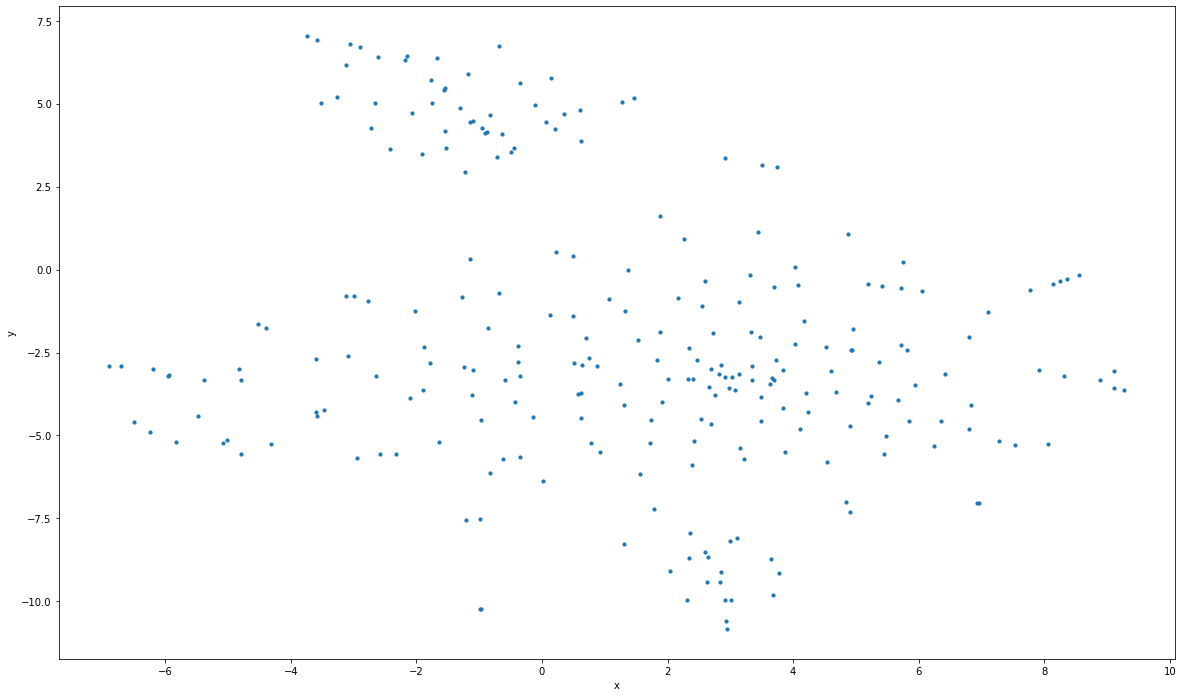

In [ ]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [ ]:
def plot_region(points,x_bounds, y_bounds):
  slce = points[
      (x_bounds[0] <= points.x) &
      (points.x <= x_bounds[1]) & 
      (y_bounds[0] <= points.y) &
      (points.y <= y_bounds[1])
  ]
  
  ax = slce.plot.scatter('x', 'y', s=35, figsize=(20, 12))
  for i, point in slce.iterrows():
      ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

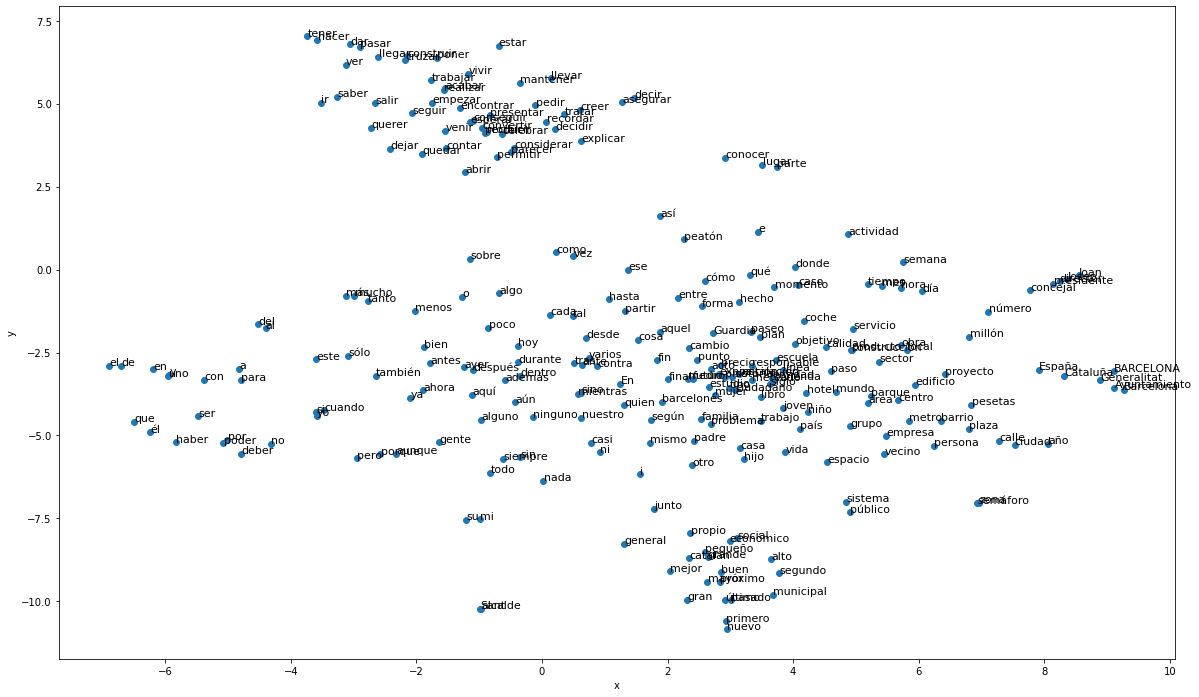

In [ ]:

plot_region(pointsspacy,x_bounds=(-200, 200), y_bounds=(-200, 200))

In [ ]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [ ]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

In [ ]:
clusters = c100

In [ ]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

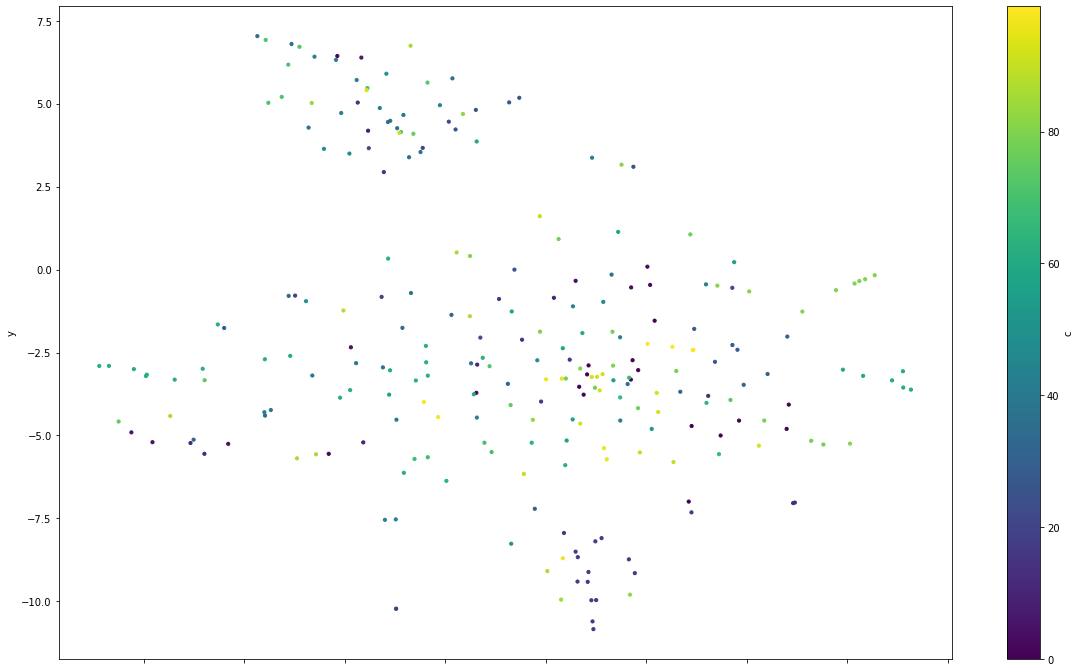

In [ ]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [ ]:
def plot_region_cluster(points,x_bounds, y_bounds):
    slce = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slce.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slce.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

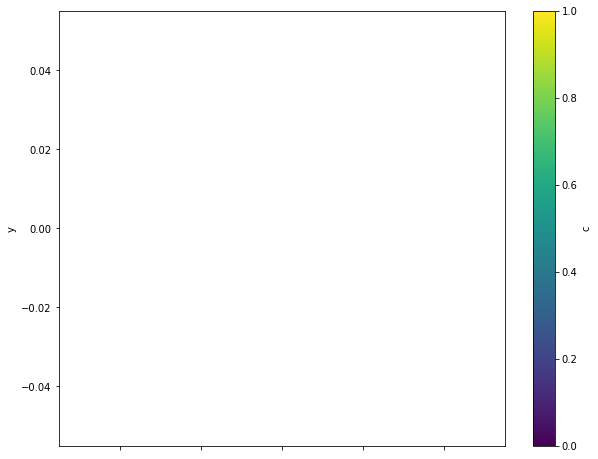

In [ ]:
plot_region_cluster(pointscluster,x_bounds=(0, 1000000), y_bounds=(10, 20))

In [ ]:
def get_word_cluster(word_):
  return [word for word in key_words if clusters[key_words[word]] == clusters[key_words[word_]]]

In [ ]:
# Stopwords
print(get_word_cluster('de'))

['el', 'y', 'de', 'en', 'a', 'uno', 'del', 'mismo', 'otro', 'este', 'con', 'todo', 'sobre', 'durante', 'varios']


In [ ]:
# Conenctes temporales, unidades de tiempo. 
#Con 150 cluster la palabra 'denuncia' se incluia en el cluster de momentos temporales

print(get_word_cluster('año'))

['año', 'mes', 'vez', 'día', 'acto', 'lugar']


In [ ]:
#Ciudades
print(get_word_cluster('España'))

['Generalitat', 'Barcelona', 'Cataluña', 'BARCELONA', 'Ayuntamiento', 'Guardia', 'España']


In [ ]:
print(get_word_cluster('millón'))

['millón']


In [ ]:

dicc['millón']

{'DEP__ROOT': 3,
 'DEP__appos': 8,
 'DEP__conj': 2,
 'DEP__dep': 1,
 'DEP__nmod': 16,
 'DEP__nsubj': 10,
 'DEP__obj': 51,
 'DEP__obl': 14,
 'NUM__': 18,
 'POS__NOUN': 105,
 'a': 4,
 'ahora': 1,
 'casi': 3,
 'con': 1,
 'dar': 1,
 'de': 90,
 'el': 28,
 'en': 9,
 'entre': 1,
 'feria': 1,
 'fotografía': 1,
 'hasta': 2,
 'luego': 1,
 'medio': 1,
 'mientras': 1,
 'mucho': 2,
 'más': 1,
 'necesitar': 1,
 'o': 1,
 'otro': 1,
 'pagar': 2,
 'para': 3,
 'permitir': 1,
 'persona': 2,
 'pesetas': 48,
 'plaza': 1,
 'por': 4,
 'que': 7,
 'recibir': 1,
 'ser': 2,
 'servir': 1,
 'si': 1,
 'sobre': 1,
 'tener': 1,
 'uno': 15,
 'venir': 1,
 'visitante': 4,
 'y': 6,
 'ya': 1,
 'él': 1}